In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

from utils import *

In [3]:
from motion.detect_human import BBoxDataset

I used [sloth](https://github.com/cvhciKIT/sloth) to annotate the images.

You can find the config file in the `data` folder (`sloth_config.py`). The command to start `sloth` that I used was: `sloth --config sloth_config.py annotations.json`. I ran the command from within the directory where I stored my train images (both the `sloth_config.py` and `annotations.json` files were inside the directory as well).

In [4]:
SZ = 500

In [5]:
# https://github.com/albu/albumentations/blob/master/notebooks/example_bboxes.ipynb
def visualize(sample):
    
    return plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(255, 0, 0),3)
    return img
    

Dataset has 1150 samples.
(500, 500, 3)


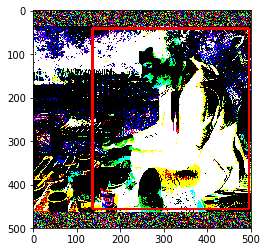

In [6]:
bbdata = BBoxDataset("coco/val2017_one_human.csv", size = SZ, type = "val")
sample = bbdata[4]
plt.imshow(visualize(sample))

Dataset has 1150 samples.
(500, 500, 3)


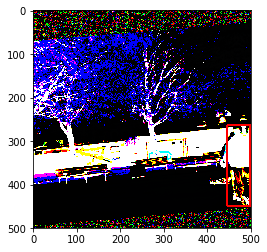

In [7]:
bbdata = BBoxDataset("coco/val2017_one_human.csv", size = SZ, type = "train")
sample = bbdata[990]
plt.imshow(visualize(sample))

In [8]:
trn_ds = BBoxDataset("coco/val2017_one_human_train.csv", size = SZ, type = "train")
val_ds = BBoxDataset("coco/val2017_one_human_val.csv", size = SZ, type = "valid")
val_ds[0][0].mean()

Dataset has 925 samples.
Dataset has 225 samples.


-0.012491897

In [9]:
NUM_WORKERS=5
BS = 8

train_dl = DataLoader(trn_ds, BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dl = DataLoader(val_ds, BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_bunch = DataBunch(train_dl, valid_dl)

In [10]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return x.sigmoid_()

In [11]:
learn = Learner(data_bunch, FlukeDetector(arch=models.resnet50), loss_func=L1Loss())

In [12]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [13]:
learn.freeze_to(-1)

In [14]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [15]:
learn.metrics = [lambda preds, targs: IoU(preds, targs).mean()]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


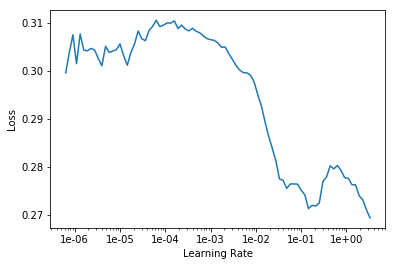

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,
1,0.190002,0.160702,0.304507
2,0.180034,0.173878,0.317142
3,0.177954,0.161625,0.330440
4,0.163993,0.143180,0.357995
5,0.152236,0.134174,0.367120


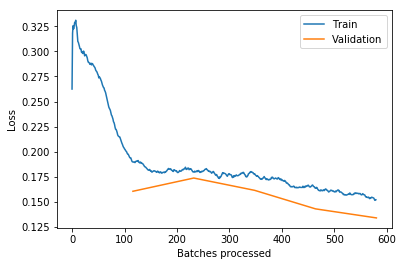

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.validate()

[0.13417444, tensor(0.3671)]

In [24]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


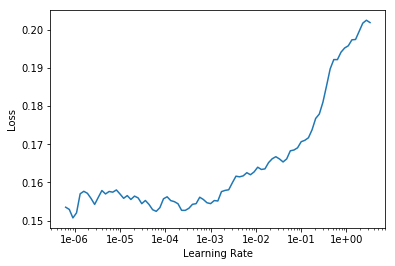

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(2,8e-5)

epoch,train_loss,valid_loss,
1,0.154028,0.137695,0.347917
2,0.152164,0.135991,0.368870


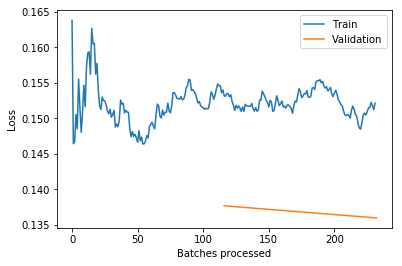

In [27]:
learn.recorder.plot_losses()

In [16]:

learn = learn.load('fastai_bbox_detect_humans_val3')
preds, targs = learn.get_preds()

Let's take a look at the results.

In [17]:
predicted_bboxes = ((preds) * SZ).numpy()
targets = ((targs) * SZ).numpy()
predicted_bboxes

array([[148.36429 , 115.84663 , 358.91388 , 374.00858 ],
       [181.89928 , 210.158   , 294.88373 , 395.95523 ],
       [153.15462 , 142.97258 , 333.7841  , 391.17212 ],
       [ 34.28313 ,   9.907405, 472.44257 , 496.4054  ],
       ...,
       [ 95.44388 ,  20.107931, 389.15775 , 492.7051  ],
       [  7.108268,   5.677845, 483.90686 , 496.87814 ],
       [193.74869 , 128.38618 , 341.99893 , 351.1891  ],
       [168.20686 , 199.62341 , 299.6669  , 434.28018 ]], dtype=float32)

In [58]:
targs*SZ

tensor([[274.0000, 118.0000, 401.0000, 434.0000],
        [115.0000, 295.0000, 160.0000, 422.0000],
        [238.0000,  88.0000, 354.0000, 291.0000],
        [ 50.0000, 112.0000, 413.0000, 350.0000],
        [136.0000,  42.0000, 494.0000, 455.0000],
        [140.0000,  46.0000, 311.0000, 384.0000],
        [ 65.0000, 160.0000, 210.0000, 441.0000],
        [166.0000,  51.0000, 322.0000, 489.0000],
        [399.0000, 163.0000, 465.0000, 327.0000],
        [162.0000,  19.0000, 336.0000, 245.0000],
        [267.0000, 239.0000, 405.0000, 347.0000],
        [ 79.0000,  70.0000, 299.0000, 373.0000],
        [139.0000,  74.0000, 296.0000, 348.0000],
        [ 10.0000,  17.0000, 168.0000, 301.0000],
        [  0.0000,  43.0000, 250.0000, 452.0000],
        [198.0000,  54.0000, 428.0000, 495.0000],
        [208.0000, 103.0000, 450.0000, 410.0000],
        [113.0000, 171.0000, 232.0000, 350.0000],
        [ 43.0000, 189.0000,  87.0000, 353.0000],
        [ 56.0000, 200.0000, 224.0000, 376.0000],


In [54]:
def draw_bbox(img, bbox, target=None, color= (255, 0, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), 255, 3)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=3)
    return img

def visualize(sample, target = None):
    
    im = plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=3)
    return im
    

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(0, 255, 0),3)
    return img


(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


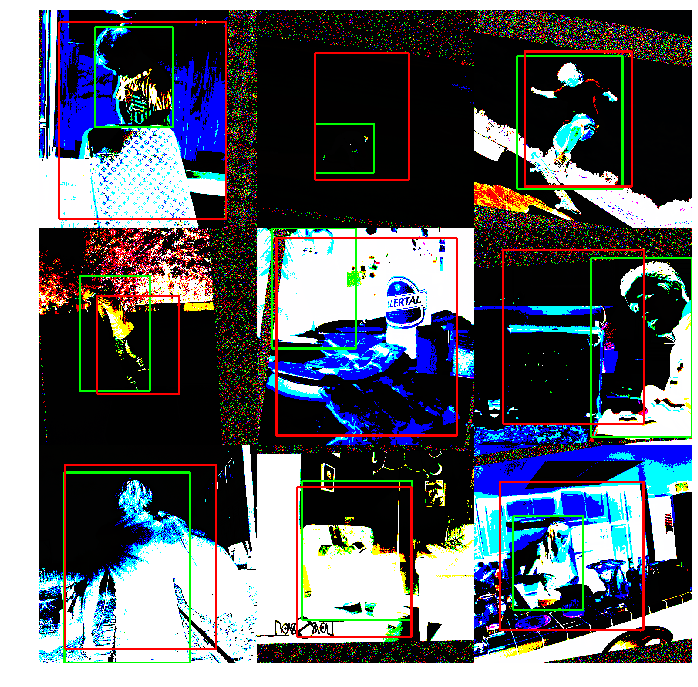

In [55]:
ims = np.stack([visualize(bbdata[i],target= predicted_bboxes[i]) for i in range(9,18)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [31]:
learn.save('fastai_bbox_detect_humans_val3')